# Stacked Analysis Plotting with Auto-Analysis

This notebook provides functionality to:
1. Check if results exist for a specified shot number
2. Run analysis automatically if required data (density, cwt, stft, etc.) is missing
3. Append new analysis results to existing HDF5 files
4. Create stacked plots with unified x-axis option

## Features
- **Auto-Analysis**: Automatically runs missing analysis components
- **Append Mode**: Adds new results to existing HDF5 files without overwriting
- **Stacked Plotting**: Stack multiple plot types (density, stft, cwt, signals) with shared x-axis
- **Flexible Configuration**: Select which plot types to display


In [1]:
import sys
from pathlib import Path

# Add project root to path
from ifi import IFI_ROOT
project_root = IFI_ROOT
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from argparse import Namespace

from ifi.analysis.plots import Plotter
from ifi.utils.file_io import load_results_from_hdf5
from ifi.db_controller.nas_db import NAS_DB
from ifi.db_controller.vest_db import VEST_DB
from ifi.utils.common import LogManager
from ifi.analysis.main_analysis import run_analysis
from ifi.analysis.interactive_analysis import create_mock_args

# Initialize logging
LogManager(level="INFO")
logger = LogManager().get_logger(__name__)

print(f"Project root: {project_root}")
print(f"Python path: {sys.path[0]}")


DEBUG    | 
[LOGS -UPDAT] Log level updated to: DEBUG



Project root: C:\Users\dhkdw\Documents\mygit\ifi
Python path: C:\Users\dhkdw\Documents\mygit\ifi


## Configuration: Shot Number and Required Data Types

Specify the shot number and which data types you need for plotting.


In [2]:
# Configuration
SHOT_NUM = 46596  # Change this to your desired shot number

# Specify which data types are required
# Options: 'density', 'stft', 'cwt', 'signals', 'vest'
# REQUIRED_DATA_TYPES = ['density', 'stft', 'cwt']  # Modify as needed
REQUIRED_DATA_TYPES = ['density', 'stft']  # Modify as needed

# Analysis options (used when running missing analysis)
ANALYSIS_OPTIONS = {
    'density': True,
    'stft': True,
    'cwt': False,
    'plot': False,  # Don't show plots during analysis
    'save_data': True,  # Save results to HDF5
    'save_plots': False,  # Don't save plots during analysis
    'scheduler': 'threads',  # Use threads for parallel processing
}

print(f"Target shot number: {SHOT_NUM}")
print(f"Required data types: {REQUIRED_DATA_TYPES}")


Target shot number: 46596
Required data types: ['density', 'stft']


## Step 1: Check Existing Results

Check if results exist for the specified shot number and which data types are available.


In [3]:
def check_existing_results(shot_num: int, base_dir: str = None) -> dict:
    """
    Check what data types are available in existing results.
    
    Args:
        shot_num: Shot number to check
        base_dir: Base directory for results (default: ifi/results)
        
    Returns:
        dict: Dictionary with availability status for each data type
    """
    if base_dir is None:
        base_dir = str(project_root / "ifi" / "results")
    
    results_dir = Path(base_dir) / str(shot_num)
    h5_files = list(results_dir.glob("*.h5")) if results_dir.exists() else []
    
    availability = {
        'file_exists': len(h5_files) > 0,
        'h5_files': [str(f) for f in h5_files],
        'density': False,
        'stft': False,
        'cwt': False,
        'signals': False,
        'vest': False,
    }
    
    if not h5_files:
        return availability
    
    # Check each HDF5 file for available data types
    for h5_file in h5_files:
        try:
            with h5py.File(h5_file, "r") as f:
                if "density_data" in f and len(f["density_data"].keys()) > 0:
                    availability['density'] = True
                if "stft_results" in f and len(f["stft_results"].keys()) > 0:
                    availability['stft'] = True
                if "cwt_results" in f and len(f["cwt_results"].keys()) > 0:
                    availability['cwt'] = True
                if "signals" in f and not f["signals"].attrs.get("empty", False):
                    availability['signals'] = True
                if "vest_data" in f and len(f["vest_data"].keys()) > 0:
                    availability['vest'] = True
        except Exception as e:
            logger.warning(f"Error checking {h5_file}: {e}")
            continue
    
    return availability

# Check existing results
availability = check_existing_results(SHOT_NUM)

print(f"\nResults check for shot {SHOT_NUM}:")
print(f"  HDF5 file exists: {availability['file_exists']}")
if availability['file_exists']:
    print(f"  HDF5 files: {availability['h5_files']}")
print(f"\nAvailable data types:")
for data_type in ['density', 'stft', 'cwt', 'signals', 'vest']:
    status = "✓" if availability[data_type] else "✗"
    required = " (REQUIRED)" if data_type in REQUIRED_DATA_TYPES else ""
    print(f"  {status} {data_type}{required}")



Results check for shot 46596:
  HDF5 file exists: True
  HDF5 files: ['C:\\Users\\dhkdw\\Documents\\mygit\\ifi\\ifi\\results\\46596\\46596.h5']

Available data types:
  ✓ density (REQUIRED)
  ✗ stft (REQUIRED)
  ✗ cwt
  ✓ signals
  ✓ vest


In [4]:
def append_results_to_hdf5(
    output_dir: str,
    shot_num: int,
    signals: dict,
    stft_results: dict,
    cwt_results: dict,
    density_data: pd.DataFrame,
    vest_data: pd.DataFrame,
) -> str:
    """
    Append analysis results to existing HDF5 file, or create new one if it doesn't exist.
    
    This function adds new data to existing groups without overwriting existing data.
    """
    import h5py
    from ifi.utils.common import ensure_dir_exists
    
    # Determine filename
    if shot_num == 0 and signals is not None and signals:
        first_source_file = list(signals.keys())[0]
        filename = f"{Path(first_source_file).stem}.h5"
    else:
        filename = f"{shot_num}.h5"
    
    filepath = Path(output_dir) / filename
    ensure_dir_exists(str(output_dir))
    
    # Use 'a' mode to append (or create if doesn't exist)
    try:
        with h5py.File(filepath, "a") as hf:
            # Update or create metadata
            if "metadata" not in hf:
                metadata = hf.create_group("metadata")
            else:
                metadata = hf["metadata"]
            metadata.attrs["shot_number"] = shot_num
            metadata.attrs["updated_at"] = pd.Timestamp.now().isoformat()
            if "created_at" not in metadata.attrs:
                metadata.attrs["created_at"] = pd.Timestamp.now().isoformat()
            metadata.attrs["ifi_version"] = "1.0"
            
            # Append signals data
            if signals is not None and signals:
                if "signals" not in hf:
                    signals_group = hf.create_group("signals")
                else:
                    signals_group = hf["signals"]
                    # Remove empty flag if it exists
                    if "empty" in signals_group.attrs:
                        del signals_group.attrs["empty"]
                
                for signal_name, signal_data in signals.items():
                    if isinstance(signal_data, pd.DataFrame):
                        # Create or update signal group
                        if signal_name not in signals_group:
                            signal_group = signals_group.create_group(signal_name)
                        else:
                            signal_group = signals_group[signal_name]
                            # Delete existing datasets to replace them
                            for key in list(signal_group.keys()):
                                del signal_group[key]
                        
                        for col in signal_data.columns:
                            signal_group.create_dataset(col, data=signal_data[col].values)
            
            # Append STFT results
            if stft_results is not None and stft_results:
                if "stft_results" not in hf:
                    stft_group = hf.create_group("stft_results")
                else:
                    stft_group = hf["stft_results"]
                
                for signal_name, stft_data in stft_results.items():
                    if isinstance(stft_data, dict):
                        if signal_name not in stft_group:
                            signal_stft_group = stft_group.create_group(signal_name)
                        else:
                            signal_stft_group = stft_group[signal_name]
                            # Delete existing datasets/attrs to replace them
                            for key in list(signal_stft_group.keys()):
                                del signal_stft_group[key]
                            for key in list(signal_stft_group.attrs.keys()):
                                del signal_stft_group.attrs[key]
                        
                        for key, value in stft_data.items():
                            if isinstance(value, np.ndarray):
                                signal_stft_group.create_dataset(key, data=value)
                            elif isinstance(value, (int, float, str)):
                                signal_stft_group.attrs[key] = value
            
            # Append CWT results
            if cwt_results is not None and cwt_results:
                if "cwt_results" not in hf:
                    cwt_group = hf.create_group("cwt_results")
                else:
                    cwt_group = hf["cwt_results"]
                
                for signal_name, cwt_data in cwt_results.items():
                    if isinstance(cwt_data, dict):
                        if signal_name not in cwt_group:
                            signal_cwt_group = cwt_group.create_group(signal_name)
                        else:
                            signal_cwt_group = cwt_group[signal_name]
                            # Delete existing datasets/attrs to replace them
                            for key in list(signal_cwt_group.keys()):
                                del signal_cwt_group[key]
                            for key in list(signal_cwt_group.attrs.keys()):
                                del signal_cwt_group.attrs[key]
                        
                        for key, value in cwt_data.items():
                            if isinstance(value, np.ndarray):
                                signal_cwt_group.create_dataset(key, data=value)
                            elif isinstance(value, (int, float, str)):
                                signal_cwt_group.attrs[key] = value
            
            # Append density data
            if density_data is not None and not density_data.empty:
                if "density_data" not in hf:
                    density_group = hf.create_group("density_data")
                else:
                    density_group = hf["density_data"]
                    # Delete existing datasets to replace them
                    for key in list(density_group.keys()):
                        del density_group[key]
                
                for col in density_data.columns:
                    density_group.create_dataset(col, data=density_data[col].values)
            
            # Append VEST data
            if vest_data is not None and not vest_data.empty:
                if "vest_data" not in hf:
                    vest_group = hf.create_group("vest_data")
                else:
                    vest_group = hf["vest_data"]
                    # Delete existing datasets to replace them
                    for key in list(vest_group.keys()):
                        del vest_group[key]
                
                for col in vest_data.columns:
                    vest_group.create_dataset(col, data=vest_data[col].values)
        
        print(f"Results appended to: {filepath}")
        return str(filepath)
    
    except Exception as e:
        logger.error(f"Error appending results to HDF5: {e}")
        return None

# Determine which data types need to be generated
missing_data_types = [dt for dt in REQUIRED_DATA_TYPES if not availability[dt]]

if missing_data_types:
    print(f"\nMissing data types: {missing_data_types}")
    print("Running analysis to generate missing data...")
    
    try:
        nas_db = NAS_DB(config_path="ifi/config.ini")
        vest_db = VEST_DB(config_path="ifi/config.ini")
        
        # Create args for analysis
        args = create_mock_args()
        args.query = [str(SHOT_NUM)]
        args.density = 'density' in missing_data_types or ANALYSIS_OPTIONS.get('density', False)
        args.stft = 'stft' in missing_data_types or ANALYSIS_OPTIONS.get('stft', False)
        args.cwt = 'cwt' in missing_data_types or ANALYSIS_OPTIONS.get('cwt', False)
        args.plot = ANALYSIS_OPTIONS.get('plot', False)
        args.save_data = False  # We'll handle saving manually with append
        args.save_plots = ANALYSIS_OPTIONS.get('save_plots', False)
        args.scheduler = ANALYSIS_OPTIONS.get('scheduler', 'threads')
        
        # Run analysis
        results = run_analysis(
            query=args.query,
            args=args,
            nas_db=nas_db,
            vest_db=vest_db,
        )
        
        # Extract results and append to HDF5
        if results and str(SHOT_NUM) in results:
            shot_results = results[str(SHOT_NUM)]
            analysis_bundle = shot_results.get('analysis_results', {})
            
            # Extract data from analysis bundle
            signals_dict = analysis_bundle.get('signals', {})
            stft_results = analysis_bundle.get('stft_results', {})
            cwt_results = analysis_bundle.get('cwt_results', {})
            
            # Handle density data (may be dict keyed by frequency)
            density_data = analysis_bundle.get('density_data', pd.DataFrame())
            if isinstance(density_data, dict):
                # Combine all frequency density DataFrames
                if density_data:
                    first_freq = list(density_data.keys())[0]
                    combined_density = density_data[first_freq].copy()
                    for freq_key, freq_df in density_data.items():
                        if freq_key != first_freq and not freq_df.empty:
                            freq_df_reindexed = freq_df.reindex(
                                combined_density.index, method="nearest", limit=1
                            )
                            for col in freq_df_reindexed.columns:
                                combined_density[f"{freq_key}GHz_{col}"] = freq_df_reindexed[col]
                    density_data = combined_density
                else:
                    density_data = pd.DataFrame()
            
            vest_data = analysis_bundle.get('vest_data', pd.DataFrame())
            
            # Append to HDF5
            output_dir = str(project_root / "ifi" / "results" / str(SHOT_NUM))
            append_results_to_hdf5(
                output_dir,
                SHOT_NUM,
                signals_dict,
                stft_results,
                cwt_results,
                density_data,
                vest_data,
            )
            
            print("\nAnalysis completed and results appended to HDF5 file.")
            
            # Refresh availability check
            availability = check_existing_results(SHOT_NUM)
        else:
            print("\nWarning: Analysis did not return expected results.")
    
    except Exception as e:
        logger.error(f"Failed to run analysis: {e}")
        raise e
else:
    print("\nAll required data types are available. Skipping analysis.")


ERROR    | Exception (client): Error reading SSH protocol banner[WinError 10054] 현재 연결은 원격 호스트에 의해 강제로 끊겼습니다
ERROR    | Traceback (most recent call last):
ERROR    |   File "c:\Users\dhkdw\Documents\mygit\ifi\.venv\lib\site-packages\paramiko\transport.py", line 2363, in _check_banner
ERROR    |     buf = self.packetizer.readline(timeout)
ERROR    |   File "c:\Users\dhkdw\Documents\mygit\ifi\.venv\lib\site-packages\paramiko\packet.py", line 395, in readline
ERROR    |     buf += self._read_timeout(timeout)
ERROR    |   File "c:\Users\dhkdw\Documents\mygit\ifi\.venv\lib\site-packages\paramiko\packet.py", line 663, in _read_timeout
ERROR    |     x = self.__socket.recv(128)
ERROR    | ConnectionResetError: [WinError 10054] 현재 연결은 원격 호스트에 의해 강제로 끊겼습니다
ERROR    | 
ERROR    | During handling of the above exception, another exception occurred:
ERROR    | 
ERROR    | Traceback (most recent call last):
ERROR    |   File "c:\Users\dhkdw\Documents\mygit\ifi\.venv\lib\site-packages\paramiko\transp


Missing data types: ['stft']
Running analysis to generate missing data...


WARNING  | [VESTB-CONN ] Direct connection failed: (2003, "Can't connect to MySQL server on '147.46.31.16' (timed out)")
WARNING  | [PHI2N-BLINE] Plasma current never exceeded threshold (5).
WARNING  | [PHI2N-BLINE] Cannot determine ramp-up for 'ip' baseline. Skipping.


In [5]:
# Load results
base_dir = str(project_root / "ifi" / "results")
results = load_results_from_hdf5(SHOT_NUM, base_dir=base_dir)

if results:
    print(f"\nLoaded results for shot {SHOT_NUM}:")
    print(f"  Available keys: {list(results.keys())}")
    
    # Extract individual data types
    density_data = results.get('density_data', None)
    stft_results = results.get('stft_results', {})
    cwt_results = results.get('cwt_results', {})
    signals = results.get('signals', {})
    vest_data = results.get('vest_data', None)
    
    if density_data is not None:
        print(f"  Density data: shape {density_data.shape}, columns {list(density_data.columns)[:3]}...")
    if stft_results:
        print(f"  STFT results: {list(stft_results.keys())}")
    if cwt_results:
        print(f"  CWT results: {list(cwt_results.keys())}")
    if signals:
        print(f"  Signals: {list(signals.keys())}")
    if vest_data is not None:
        print(f"  VEST data: shape {vest_data.shape}")
else:
    print(f"\nNo results found for shot {SHOT_NUM}")
    density_data = None
    stft_results = {}
    cwt_results = {}
    signals = {}
    vest_data = None


Loading results from C:\Users\dhkdw\Documents\mygit\ifi\ifi\results\46596\46596.h5
Loaded metadata: {'created_at': '2025-11-27T17:24:25.046499', 'ifi_version': '1.0', 'shot_number': np.int64(46596)}
Loaded signal 'freq_280.0_GHz' with shape (20000000, 4)
Loaded density data with shape (20000000, 1)
Loaded VEST data with shape (45315, 4)

Loaded results for shot 46596:
  Available keys: ['metadata', 'signals', 'density_data', 'vest_data']
  Density data: shape (20000000, 1), columns ['ne_CH1_46596_ALL.csv']...
  Signals: ['freq_280.0_GHz']
  VEST data: shape (45315, 4)


## Step 4: Create Stacked Plots

Create stacked plots with optional unified x-axis. Select which plot types to display.


Creating stacked plots...

Plot availability:
  Ip: True
  280GHz density: False (0 columns)
  94GHz density: False (0 columns)
  Spectroscopy: False
  Mirnove: False


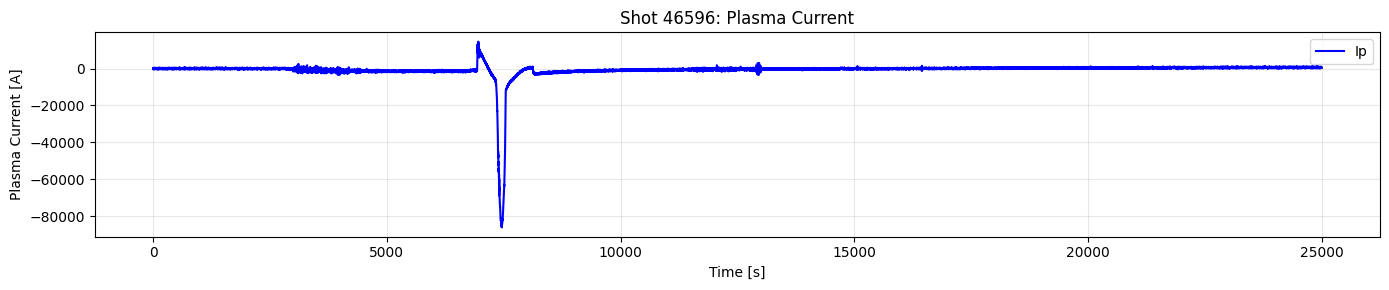


Stacked plots created successfully.


In [6]:
# Configuration for stacked plotting
# VEST field IDs (from VEST database)
VEST_FIELDS = {
    'Ip': 109,           # Plasma current
    'H_alpha': 101,      # H alpha 656 nm
    'O_I': 214,          # O I 777 nm
    'C_III': 140,        # C III
    'Mirnove_Outer': 171, # Outer Mirnove signal
}

# Create stacked plots (script style, not function)
print("Creating stacked plots...")
# Check availability of each plot type
vest_data = results.get('vest_data', None)
density_data = results.get('density_data', None)

# 1st row: Plasma current (Ip)
has_ip = False
ip_cols = []
if vest_data is not None:
    # Check if Ip column exists (field 109)
    ip_cols = [col for col in vest_data.columns if '109' in str(col) or 'Ip' in str(col) or col == 'Ip']
    has_ip = len(ip_cols) > 0

# 2nd row: 280GHz density
has_280ghz = False
density_280ghz_cols = []
if density_data is not None:
    # Find 280GHz density columns
    # Pattern: columns starting with "280GHz_" or containing "280GHz" or "280" (but not "94")
    for col in density_data.columns:
        col_str = str(col)
        # Check for 280GHz prefix or 280GHz in name
        if col_str.startswith('280GHz_') or '280GHz' in col_str:
            density_280ghz_cols.append(col)
        # Also check for columns with "280" but not "94" (to avoid false matches)
        elif '280' in col_str and '94' not in col_str and '280GHz_' not in col_str:
            # Additional check: make sure it's not a 94GHz column with "280" in filename
            if not any(x in col_str for x in ['94GHz', '94.0']):
                density_280ghz_cols.append(col)
    has_280ghz = len(density_280ghz_cols) > 0

# 3rd row: 94GHz density
has_94ghz = False
density_94ghz_cols = []
if density_data is not None:
    # Find 94GHz density columns
    # Pattern: columns starting with "94GHz_" or containing "94GHz" or "94" (but not "280")
    for col in density_data.columns:
        col_str = str(col)
        # Check for 94GHz prefix or 94GHz in name
        if col_str.startswith('94GHz_') or '94GHz' in col_str or '94.0GHz' in col_str:
            density_94ghz_cols.append(col)
        # Also check for columns with "94" but not "280" (to avoid false matches)
        elif '94' in col_str and '280' not in col_str:
            # Make sure it's not already in 280GHz list and doesn't have 280GHz prefix
            if col not in density_280ghz_cols and '280GHz' not in col_str:
                density_94ghz_cols.append(col)
    has_94ghz = len(density_94ghz_cols) > 0
    
# 4th row: H alpha, O I 777nm, C III
has_spectroscopy = False
spec_cols = {}
if vest_data is not None:
    # H alpha (field 101)
    h_alpha_cols = [col for col in vest_data.columns if '101' in str(col) or 'H_alpha' in str(col) or 'Halpha' in str(col)]
    # O I 777nm (field 214)
    o_i_cols = [col for col in vest_data.columns if '214' in str(col) or 'O_I' in str(col) or 'O I' in str(col)]
    # C III (field 140)
    c_iii_cols = [col for col in vest_data.columns if '140' in str(col) or 'C_III' in str(col) or 'C III' in str(col)]
    spec_cols = {'H_alpha': h_alpha_cols, 'O_I': o_i_cols, 'C_III': c_iii_cols}
    has_spectroscopy = len(h_alpha_cols) > 0 or len(o_i_cols) > 0 or len(c_iii_cols) > 0

# 5th row: Outer Mirnove signal
has_mirnove = False
mirnove_cols = []
if vest_data is not None:
    # Outer Mirnove (field 171)
    mirnove_cols = [col for col in vest_data.columns if '171' in str(col) or 'Mirnove' in str(col) or 'mirnove' in str(col)]
    has_mirnove = len(mirnove_cols) > 0

# Build plot list (skip missing 1st and 3rd if needed)
plot_list = []
if has_ip:
    plot_list.append(('ip', None))
if has_280ghz:
    plot_list.append(('280ghz', density_280ghz_cols))
if has_94ghz:
    plot_list.append(('94ghz', density_94ghz_cols))
if has_spectroscopy:
    plot_list.append(('spectroscopy', spec_cols))
if has_mirnove:
    plot_list.append(('mirnove', mirnove_cols))

print(f"\nPlot availability:")
print(f"  Ip: {has_ip}")
print(f"  280GHz density: {has_280ghz} ({len(density_280ghz_cols)} columns)")
print(f"  94GHz density: {has_94ghz} ({len(density_94ghz_cols)} columns)")
print(f"  Spectroscopy: {has_spectroscopy}")
print(f"  Mirnove: {has_mirnove}")

if not plot_list:
    print("\nNo plots to create based on available data.")
else:
    n_plots = len(plot_list)
    fig, axes = plt.subplots(n_plots, 1, figsize=(14, 3 * n_plots), sharex=True)
    if n_plots == 1:
        axes = [axes]
    
    # Extract common time axis
    common_time = None
    if density_data is not None and hasattr(density_data, 'index') and len(density_data.index) > 0:
        common_time = density_data.index.values
    elif results.get('signals'):
        first_signal = list(results['signals'].values())[0]
        if 'TIME' in first_signal.columns:
            common_time = first_signal['TIME'].values
    
    plot_idx = 0
    
    # Plot each row
    for plot_type, plot_data in plot_list:
        ax = axes[plot_idx]
        
        if plot_type == 'ip':
            # 1st row: Plasma current
            if vest_data is not None:
                ip_col = ip_cols[0] if ip_cols else None
                if ip_col:
                    time_ip = vest_data.index.values if hasattr(vest_data, 'index') else None
                    if time_ip is None and common_time is not None:
                        time_ip = common_time[:len(vest_data)]
                    ax.plot(time_ip, vest_data[ip_col].values, label='Ip', color='blue', linewidth=1.5)
                    ax.set_ylabel("Plasma Current [A]")
                    ax.set_title(f"Shot {SHOT_NUM}: Plasma Current")
                    ax.legend()
                    ax.grid(True, alpha=0.3)
        
        elif plot_type == '280ghz':
            # 2nd row: 280GHz density
            if density_data is not None and plot_data:
                time_data = density_data.index.values if hasattr(density_data, 'index') else None
                if time_data is None and common_time is not None:
                    time_data = common_time[:len(density_data)]
                for col in plot_data:
                    ax.plot(time_data, density_data[col].values, label=col, linewidth=1.5)
                ax.set_ylabel("Density [m^-3]")
                ax.set_title(f"Shot {SHOT_NUM}: 280GHz Density")
                ax.legend()
                ax.grid(True, alpha=0.3)
        
        elif plot_type == '94ghz':
            # 3rd row: 94GHz density
            if density_data is not None and plot_data:
                time_data = density_data.index.values if hasattr(density_data, 'index') else None
                if time_data is None and common_time is not None:
                    time_data = common_time[:len(density_data)]
                for col in plot_data:
                    ax.plot(time_data, density_data[col].values, label=col, linewidth=1.5)
                ax.set_ylabel("Density [m^-3]")
                ax.set_title(f"Shot {SHOT_NUM}: 94GHz Density")
                ax.legend()
                ax.grid(True, alpha=0.3)
        
        elif plot_type == 'spectroscopy':
            # 4th row: H alpha, O I 777nm, C III
            if vest_data is not None and plot_data:
                time_spec = vest_data.index.values if hasattr(vest_data, 'index') else None
                if time_spec is None and common_time is not None:
                    time_spec = common_time[:len(vest_data)]
                
                colors = {'H_alpha': 'red', 'O_I': 'green', 'C_III': 'blue'}
                for spec_name, spec_col_list in plot_data.items():
                    if spec_col_list:
                        col = spec_col_list[0]
                        ax.plot(time_spec, vest_data[col].values, label=spec_name, color=colors.get(spec_name, 'black'), linewidth=1.5)
                ax.set_ylabel("Intensity [a.u.]")
                ax.set_title(f"Shot {SHOT_NUM}: Spectroscopy (H alpha, O I 777nm, C III)")
                ax.legend()
                ax.grid(True, alpha=0.3)
        
        elif plot_type == 'mirnove':
            # 5th row: Outer Mirnove signal
            if vest_data is not None and plot_data:
                time_mirnove = vest_data.index.values if hasattr(vest_data, 'index') else None
                if time_mirnove is None and common_time is not None:
                    time_mirnove = common_time[:len(vest_data)]
                if mirnove_cols:
                    col = mirnove_cols[0]
                    ax.plot(time_mirnove, vest_data[col].values, label='Outer Mirnove', color='purple', linewidth=1.5)
                    ax.set_ylabel("Amplitude [a.u.]")
                    ax.set_title(f"Shot {SHOT_NUM}: Outer Mirnove Signal")
                    ax.legend()
                    ax.grid(True, alpha=0.3)
        
        plot_idx += 1
    
    # Set x-axis label on bottom plot
    if plot_idx > 0:
        axes[-1].set_xlabel("Time [s]")
    
    plt.tight_layout()
    plt.show()
    print("\nStacked plots created successfully.")


## Step 5: Create STFT Plots

Create STFT spectrograms for 280GHz signals in specified layouts.



Creating STFT plots for 280GHz signals...
STFT results not found. Computing STFT from signal data...
  Detected sampling frequency: 625.00 MHz
  ✓ Computed STFT for freq_280.0_GHz_CH0
  ✓ Computed STFT for freq_280.0_GHz_CH1
  ✓ Computed STFT for freq_280.0_GHz_CH2


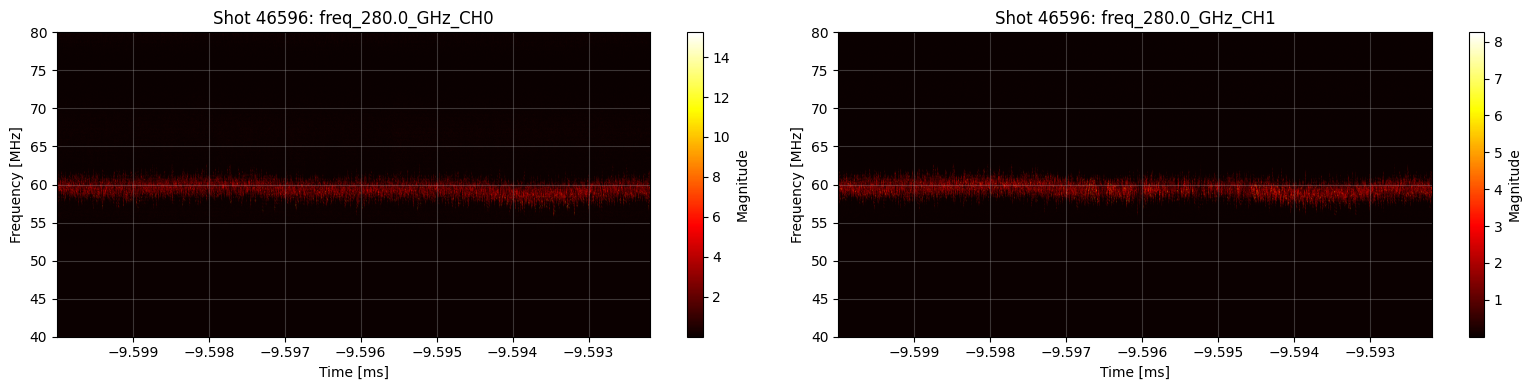

✓ Created 1-by-2 STFT plot (CH0, CH1)
⚠ Could not find enough STFT data for 3-by-2 plot (found 0/6)
  Available STFT keys: ['freq_280.0_GHz_CH0', 'freq_280.0_GHz_CH1', 'freq_280.0_GHz_CH2']


In [9]:
# Create STFT plots for 280GHz signals (script style)
print("\nCreating STFT plots for 280GHz signals...")

from ifi.analysis.spectrum import SpectrumAnalysis

stft_results = results.get('stft_results', {})
signals = results.get('signals', {})

# If STFT results are missing, compute STFT from signals
if not stft_results and signals:
    print("STFT results not found. Computing STFT from signal data...")
    analyzer = SpectrumAnalysis()
    stft_results = {}
    
    # Get sampling frequency (typically 50 MHz for IFI data)
    fs = 50e6  # Default sampling frequency
    
    # Try to get fs from first signal if available
    if signals:
        first_signal_key = list(signals.keys())[0]
        first_signal_df = signals[first_signal_key]
        if 'TIME' in first_signal_df.columns:
            time_data = first_signal_df['TIME'].values
            if len(time_data) > 1:
                dt = np.mean(np.diff(time_data))
                if dt > 0:
                    fs = 1.0 / dt
                    print(f"  Detected sampling frequency: {fs/1e6:.2f} MHz")
    
    # Compute STFT for each signal
    for signal_name, signal_df in signals.items():
        if 'TIME' not in signal_df.columns:
            continue
        
        # Get channel columns (exclude TIME)
        channel_cols = [col for col in signal_df.columns if col != 'TIME']
        
        for ch_col in channel_cols[:3]:  # Process first 3 channels
            signal_data = signal_df[ch_col].values
            time_signal = signal_df['TIME'].values
            
            try:
                # Compute STFT
                freqs, times, stft_matrix = analyzer.compute_stft_sqpy(
                    signal_data, 
                    fs=fs,
                    t_start=time_signal[0] if len(time_signal) > 0 else 0.0
                )
                
                # Store STFT results
                stft_key = f"{signal_name}_{ch_col}"
                stft_results[stft_key] = {
                    'freq': freqs,
                    'time': times,
                    'stft_matrix': stft_matrix,
                    'center_freq': analyzer.find_center_frequency_fft(signal_data, fs)
                }
                print(f"  ✓ Computed STFT for {stft_key}")
            except Exception as e:
                print(f"  ✗ Failed to compute STFT for {signal_name}/{ch_col}: {e}")
                continue

if not stft_results:
    print("No STFT results available and could not compute from signals.")
else:
    shot_str = str(SHOT_NUM)
    
    # First plot: CH0 and CH1 (1-by-2)
    ch0_key = None
    ch1_key = None
    
    # Try to find CH0 and CH1 STFT results
    for key in stft_results.keys():
        key_lower = key.lower()
        # Look for CH0 patterns
        if ch0_key is None:
            if f"ch0_{shot_str}_056" in key_lower or (f"ch0_{shot_str}" in key_lower and "_056" in key_lower):
                ch0_key = key
            elif "ch0" in key_lower and shot_str in key_lower:
                ch0_key = key
        # Look for CH1 patterns
        if ch1_key is None:
            if f"ch1_{shot_str}_056" in key_lower or (f"ch1_{shot_str}" in key_lower and "_056" in key_lower):
                ch1_key = key
            elif "ch1" in key_lower and shot_str in key_lower:
                ch1_key = key
    
    # If not found by pattern, use first two available STFT results
    if ch0_key is None or ch1_key is None:
        available_keys = list(stft_results.keys())
        if len(available_keys) >= 2:
            if ch0_key is None:
                ch0_key = available_keys[0]
            if ch1_key is None and ch0_key != available_keys[1]:
                ch1_key = available_keys[1]
            elif ch1_key is None and len(available_keys) >= 2:
                ch1_key = available_keys[1] if available_keys[1] != ch0_key else available_keys[0]
    
    if ch0_key and ch1_key:
        fig1, axes1 = plt.subplots(1, 2, figsize=(16, 4))
        
        for idx, (key, ax) in enumerate([(ch0_key, axes1[0]), (ch1_key, axes1[1])]):
            stft_data = stft_results[key]
            time_stft = stft_data.get('time', stft_data.get('time_STFT', None))
            freq_stft = stft_data.get('freq', stft_data.get('freq_STFT', None))
            stft_matrix = stft_data.get('stft_matrix', stft_data.get('STFT_matrix', None))
            
            if stft_matrix is not None and time_stft is not None and freq_stft is not None:
                im = ax.pcolormesh(
                    time_stft*1e3, freq_stft/1e6, np.abs(stft_matrix),
                    shading='gouraud', cmap='hot'
                )
                ax.set_title(f"Shot {SHOT_NUM}: {key}")
                ax.set_xlabel("Time [ms]")
                ax.set_ylabel("Frequency [MHz]")
                # ax.set_xlim(0, fs/2)
                ax.set_ylim(40, 80)
                plt.colorbar(im, ax=ax, label="Magnitude")
                ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        print("✓ Created 1-by-2 STFT plot (CH0, CH1)")
    else:
        print(f"⚠ Could not find CH0 or CH1 STFT data for shot {SHOT_NUM}")
    
    # Second plot: 3-by-2 layout
    # 1st row: CH0_<shotnum>_056, CH1_<shotnum>_056
    # 2nd row: CH2_<shotnum>_056, CH0_<shotnum>_789
    # 3rd row: CH1_<shotnum>_789, CH2_<shotnum>_789
    
    channel_patterns = [
        (f"CH0_{shot_str}_056", "CH0"),
        (f"CH1_{shot_str}_056", "CH1"),
        (f"CH2_{shot_str}_056", "CH2"),
        (f"CH0_{shot_str}_789", "CH0"),
        (f"CH1_{shot_str}_789", "CH1"),
        (f"CH2_{shot_str}_789", "CH2"),
    ]
    
    found_keys = []
    for pattern, ch_name in channel_patterns:
        # Try exact match first
        found = None
        for key in stft_results.keys():
            key_lower = key.lower()
            pattern_lower = pattern.lower()
            if pattern_lower in key_lower:
                found = key
                break
        if not found:
            # Try partial match
            for key in stft_results.keys():
                key_lower = key.lower()
                if ch_name.lower() in key_lower and (f"_{shot_str}_056" in key_lower or f"_{shot_str}_789" in key_lower):
                    # Check if it matches the pattern (056 or 789)
                    suffix = pattern.split('_')[2]  # 056 or 789
                    if suffix in key_lower:
                        found = key
                        break
        found_keys.append(found)
    
    if sum(1 for k in found_keys if k is not None) >= 4:  # At least 4 out of 6
        fig2, axes2 = plt.subplots(3, 2, figsize=(16, 12))
        axes2 = axes2.flatten()
        
        for idx, (pattern, ch_name) in enumerate(channel_patterns):
            key = found_keys[idx]
            ax = axes2[idx]
            
            if key and key in stft_results:
                stft_data = stft_results[key]
                time_stft = stft_data.get('time', stft_data.get('time_STFT', None))
                freq_stft = stft_data.get('freq', stft_data.get('freq_STFT', None))
                stft_matrix = stft_data.get('stft_matrix', stft_data.get('STFT_matrix', None))
                
                if stft_matrix is not None and time_stft is not None and freq_stft is not None:
                    im = ax.pcolormesh(
                        time_stft*1e3, freq_stft/1e6, np.abs(stft_matrix),
                        shading='gouraud', cmap='hot'
                    )
                    ax.set_title(f"Shot {SHOT_NUM}: {key}")
                    ax.set_xlabel("Time [ms]")
                    ax.set_ylabel("Frequency [MHz]")
                    # ax.set_xlim(0, fs/2)
                    ax.set_ylim(10, 50)
                    plt.colorbar(im, ax=ax, label="Magnitude")
                    ax.grid(True, alpha=0.3)
                else:
                    ax.text(0.5, 0.5, f"No data for {pattern}", 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f"Shot {SHOT_NUM}: {pattern} (missing)")
            else:
                ax.text(0.5, 0.5, f"Not found: {pattern}", 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f"Shot {SHOT_NUM}: {pattern} (missing)")
        
        plt.tight_layout()
        plt.show()
        print("✓ Created 3-by-2 STFT plot")
    else:
        print(f"⚠ Could not find enough STFT data for 3-by-2 plot (found {sum(1 for k in found_keys if k is not None)}/6)")
        print(f"  Available STFT keys: {list(stft_results.keys())[:10]}")


## Summary

This notebook provides:
1. ✓ Automatic checking of existing results for specified shot number
2. ✓ Automatic analysis execution for missing data types
3. ✓ Append mode for adding new results to existing HDF5 files
4. ✓ Stacked plotting with specific layout:
   - 1st row: Plasma current (Ip)
   - 2nd row: 280GHz density
   - 3rd row: 94GHz density
   - 4th row: H alpha, O I 777nm, C III
   - 5th row: Outer Mirnove signal
5. ✓ STFT plots for 280GHz signals:
   - 1-by-2 layout: CH0, CH1
   - 3-by-2 layout: 6 channels (CH0/CH1/CH2 for 056 and 789)

### Usage Tips
- Modify `SHOT_NUM` to analyze different shots
- Adjust `REQUIRED_DATA_TYPES` to specify which analyses are needed
- Missing rows (1st or 3rd) are automatically skipped
- STFT plots show available channels, missing ones are marked
